In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from glob import glob
import re
import os
%matplotlib inline

In [30]:
INCLUDE_SWIFT_LONG_LIBS = False
WORKFLOW_BRANCH = "a"

# Analysis plots for alternative workflow branch

The "b" workflow includes a re-processing of the data with downsampling based on coverage instead of read count.

This notebook recreates many plots that are produced in other notebooks for the main workflow (downsample based on read count).

The code is copy/pasted from the original notebooks, then condensed to produce only the most important plots, and adjusted for alternative file naming.

The `savefig` function in this notebook writes a figure with file name prefix `b_`.

# General plots, from Main_analysis notebook

In [31]:
def load_picard(path):
    with open(path) as f:
        mode = None
        metrics_header = None
        metrics_data = {}
        histogram_series = []
        histogram_data = []
        for l in f:
            line = l.rstrip("\r\n")
            if mode == 'metrics':
                metrics_header = line.split()
                mode = 'metrics2'
            elif mode == 'metrics2':
                if line != "":
                    metrics_data = dict(zip(metrics_header, line.split()))
                else:
                    mode = None
            elif mode == 'histogram':
                histogram_series = line.split()
                histogram_data = [list() for _ in histogram_series]
                mode = 'histogram2'
            elif mode == 'histogram2':
                if line != "":
                    for i, value in enumerate(line.split()):
                        histogram_data[i].append(value)
                else:
                    mode = None
            elif line.startswith("## METRICS CLASS"):
                mode = 'metrics'
            elif line.startswith("## HISTOGRAM"):
                mode = 'histogram'
        if histogram_series:
            #metrics_data['histograms'] = dict(zip(histogram_series, histogram_data))
            for name, data in zip(histogram_series, histogram_data):
                metrics_data[name] = [float(x) for x in data]
    return metrics_data
samples = []
for bam in glob("{}30_downsample/*_DS_MD.AlignmentSummaryMetrics.txt".format(WORKFLOW_BRANCH)):
    basepath = re.sub(r"_MD\.AlignmentSummaryMetrics\.txt$", "", bam)
    data = {}
    try:
        for metrics in ['_MD.AlignmentSummaryMetrics', '_MD.InsertSizeMetrics',
                        '.MarkDuplicatesMetrics', '_MD.WgsMetrics']:
            if metrics == '.MarkDuplicatesMetrics' and WORKFLOW_BRANCH == 'd':
                new_data = {'LIBRARY': re.search(r"/(.*)_DS$", basepath).group(1)}
            else:
                new_data = load_picard("{}{}.txt".format(basepath, metrics))
            if any(k in data for k in new_data):
                print("Duplicate key {} found in {}".format(k, metrics))
            data.update(new_data)
    except FileNotFoundError as e:
        print("File {} not found, skipping this sample.".format(e.filename))
        continue
    samples.append(data)

print("Sample count", len(samples))
inital_read_counts = []
for alignment_txt in glob("20_piccard/*.AlignmentSummaryMetrics.txt"):
    library = re.match(r"([^/]+)\.AlignmentSummaryMetrics.txt", os.path.basename(alignment_txt)).group(1)
    new_data = load_picard(alignment_txt)
    inital_read_counts.append({'LIBRARY': library, 'INITIAL_READS': int(new_data['TOTAL_READS']),
                                    'INITIAL_READS_PER_END': int(new_data['TOTAL_READS']) / 2,
                                    'INITIAL_READS_ALIGNED': int(new_data['PF_READS_ALIGNED']),
                                    'INITIAL_READS_ALIGNED_PER_END': int(new_data['PF_READS_ALIGNED']) / 2})
    
main_df = pd.DataFrame(samples).reindex().apply(pd.to_numeric, axis=0, errors='ignore')
in_reads_df = pd.DataFrame(inital_read_counts)

df = pd.merge(
        main_df, 
        in_reads_df,  
        on='LIBRARY')
df['Kit'] = pd.Categorical(df.LIBRARY.str.split("-").str.get(0), ordered=True)
df['Conc'] = pd.Categorical(df.LIBRARY.str.split("-").str.get(1), categories=['10ng', '100ng'])

if not INCLUDE_SWIFT_LONG_LIBS:
    df = df.loc[df.Kit != "Swiftlong"]
    df.Kit = df.Kit.cat.set_categories(['Kapa', 'NEB', 'Nextera', 'Quanta', 'Swift2S'])
else:
    df.Kit = df.Kit.cat.set_categories(['Kapa', 'NEB', 'Nextera', 'Quanta', 'Swift2S', 'Swiftlong'])
    df_100 = df.loc[df.Conc == "100ng"]
df.head(n=1)
print("Number of entries: ", len(df))



def savefig(name, main=True):
    for fmt in ['pdf', 'png']:
        if main:
            if INCLUDE_SWIFT_LONG_LIBS:
                plt.savefig(f'plots-main-withLong/{WORKFLOW_BRANCH}_{name}.{fmt}')
            else:
                plt.savefig(f'plots-main/{WORKFLOW_BRANCH}_{name}.{fmt}')
        else:
            if INCLUDE_SWIFT_LONG_LIBS:
                plt.savefig(f'plots-suppl-withLong/{WORKFLOW_BRANCH}_{name}.{fmt}')
            else:
                plt.savefig(f'plots-suppl/{WORKFLOW_BRANCH}_{name}.{fmt}')

Sample count 48
Number of entries:  40


In [32]:
def lineplotHueKit(**kwargs):
    return sns.lineplot(**kwargs, hue='Kit', hue_order=kwargs['data'].Kit.cat.categories)

In [33]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

# Quality of downsampling

Depending on `WORKFLOW_BRANCH`, either the reads per end or the coverage should be close to the same for all libraries.

Text(0.5, 1.0, 'Downsampled reads')

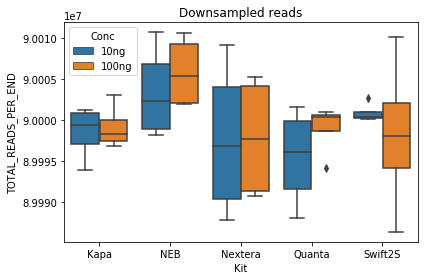

In [34]:
df['TOTAL_READS_PER_END'] = df['TOTAL_READS'] / 2
sns.boxplot(data=df, x='Kit', y='TOTAL_READS_PER_END', hue='Conc')
plt.title('Downsampled reads')

Text(0.5, 0, '')

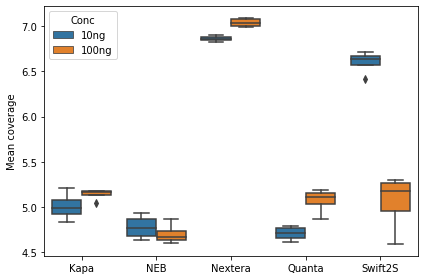

In [44]:
sns.boxplot(data=df, x="Kit", y="MEAN_COVERAGE", hue="Conc")
plt.ylabel('Mean coverage')
plt.xlabel("")

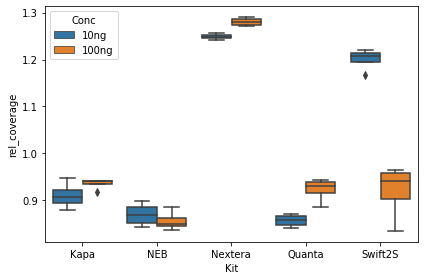

In [36]:
df['rel_coverage'] = df.MEAN_COVERAGE / df.MEAN_COVERAGE.mean()
sns.boxplot(data=df, x="Kit", y="rel_coverage", hue="Conc")

In [37]:
print(f"Workflow branch {WORKFLOW_BRANCH} std deviation: {df.MEAN_COVERAGE.std():.3}")

Workflow branch a std deviation: 0.913


### Notes about mean coverage standard deviation values in all workflow branches

|workflow branch | mean coverage stdev |
|-|-|
|a| todo re-run |
|b| 0.143 |
|c| 0.011 |
|d| 0.005 |

## Percentage aligning to the human genome

Text(0.5, 0, '')

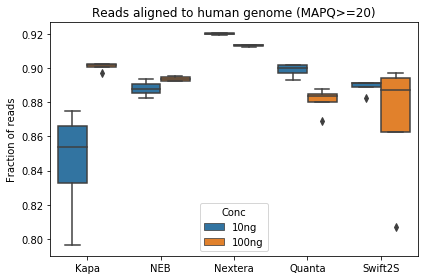

In [38]:
df['PCT_HQ_PF_READS_ALIGNED'] = df.PF_HQ_ALIGNED_READS / df.TOTAL_READS
sns.boxplot(data=df, x='Kit', y='PCT_HQ_PF_READS_ALIGNED', hue='Conc')
plt.title('Reads aligned to human genome (MAPQ>=20)')
plt.ylabel("Fraction of reads")
plt.xlabel("")
#savefig("aligned_reads_human")

# Coverage

In [39]:
hist_rows = df[['coverage', 'high_quality_coverage_count']].apply(pd.Series.explode).apply(pd.to_numeric)
long_df = df.drop(['coverage', 'high_quality_coverage_count'], axis=1).join(hist_rows)

In [40]:
print("Histogram sum", long_df.loc[long_df.LIBRARY=='Kapa-10ng-1', 'high_quality_coverage_count'].sum())
print("Genome size", long_df.GENOME_TERRITORY.max())

Histogram sum 2934876545.0
Genome size 2934876545


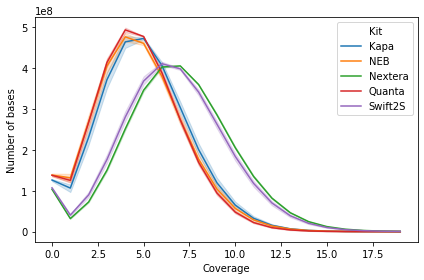

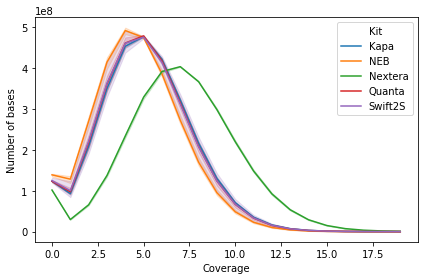

In [41]:
for conc in ["10ng", "100ng"]:
    medium_df = long_df[(long_df.coverage < 20)&(long_df.Conc == conc)]
    plt.figure()
    lineplotHueKit(x='coverage', y='high_quality_coverage_count', data=medium_df)
    plt.ylabel("Number of bases")
    plt.xlabel("Coverage")
    savefig("coverage_picard_{}".format(conc), False)
    plt.show()

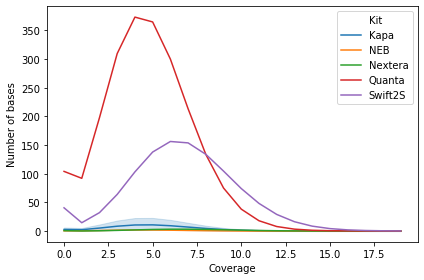

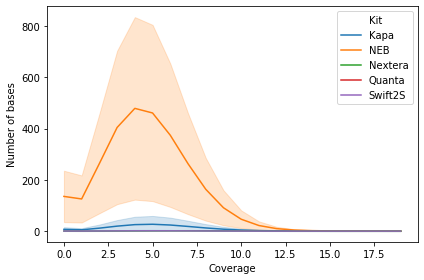

In [42]:
for conc in ["10ng", "100ng"]:
    medium_df = long_df[(long_df.coverage < 20)&(df.Conc == conc)].copy()
    medium_df['global_mean_count'] = medium_df.groupby('coverage')['high_quality_coverage_count'].mean()
    medium_df['count_diff'] = medium_df.high_quality_coverage_count / medium_df.global_mean_count
    plt.figure()
    lineplotHueKit(x='coverage', y='count_diff', data=medium_df)
    plt.ylabel("Number of bases")
    plt.xlabel("Coverage")
    # TODO: What plot
    #savefig("coverage_picard_{}".format(conc))
    plt.show()

### For comparison, deeptools plots, not used

10ng 


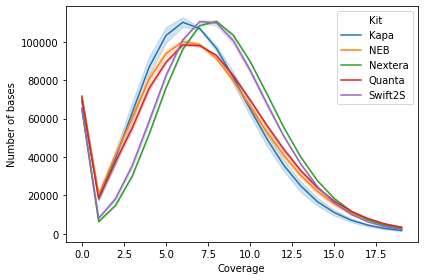

100ng 


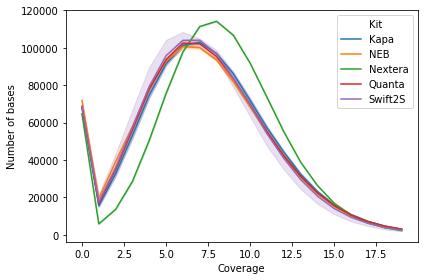

10ng -hq


FileNotFoundError: [Errno 2] File a50_deeptools_summary/coverage-hq_10ng.txt does not exist: 'a50_deeptools_summary/coverage-hq_10ng.txt'

In [43]:
total_bases = []
for q in ["", "-hq"]:
    for conc in ["10ng", "100ng"]:
        print(conc, q)
        cov_matrix = pd.read_csv("{}50_deeptools_summary/coverage{}_{}.txt".format(WORKFLOW_BRANCH, q, conc),
                                 skiprows=1, sep='\t')
        cov_matrix.columns = [
            c.replace("'", "").replace("_DS_MD.bam", "")
            for c in cov_matrix.columns
        ]
        if not INCLUDE_SWIFT_LONG_LIBS:
            cov_matrix = cov_matrix[[c for c in cov_matrix.columns if not c.startswith("Swiftlong")]]
        columns = cov_matrix.columns[3:]
        counts_matrix = cov_matrix.iloc[:, 3:].apply(pd.value_counts)

        counts_long = counts_matrix.reset_index().rename({'index': 'Coverage'}, axis=1).melt(id_vars=['Coverage'], value_name="NumReads")
        counts_long['Kit'] = pd.Categorical(counts_long.variable.str.split("-").str.get(0))
        counts_long['Replicate'] = counts_long.variable.str.split("-").str.get(2)
        total_bases.append(counts_long.loc[counts_long.variable=='Kapa-{}-1'.format(conc), 'Coverage'].sum())
        #counts_long = counts_long.groupby(['Kit', 'Replicate']).apply(reverse_cum_sum)
        counts_medium = counts_long[counts_long.Coverage < 20]
        plt.figure()
        lineplotHueKit(x='Coverage', y='NumReads', data=counts_medium)
        plt.ylabel("Number of bases")
        plt.show()
print(total_bases)

# Insert sizes

In [ ]:
# Pretty if n_boot ~ 1000, ugly but fast if around 50
n_boot = 1000

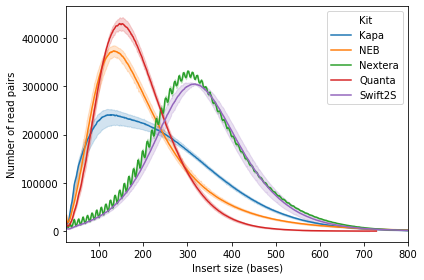

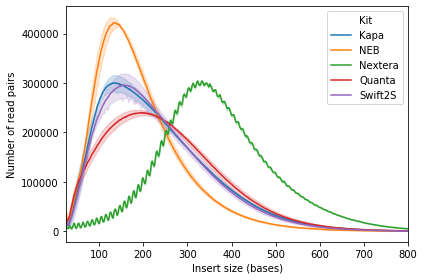

In [53]:
is_hist_rows = df[['insert_size', 'All_Reads.fr_count']].apply(pd.Series.explode).apply(pd.to_numeric)
is_long_df = df.drop(['insert_size', 'All_Reads.fr_count'], axis=1).join(is_hist_rows)

for conc in ["10ng", "100ng"]:
    is_medium_df = is_long_df[(is_long_df.insert_size < 800)&(is_long_df.insert_size>25)&(is_long_df.Conc == conc)]
    plt.figure()
    lineplotHueKit(x='insert_size', y='All_Reads.fr_count', data=is_medium_df)
    plt.ylabel("Number of read pairs")
    plt.xlabel("Insert size (bases)")
    plt.xlim(25, 800)
    savefig("insertSize_picard_{}".format(conc))
    plt.show()

## Deeptools plot here

This is the same plot, generated in a different way, by deepTools.

Not used for publication.

In [ ]:
insertSizeDatas = [pd.read_csv(
                        "{}50_deeptools_summary/insertSize_{}.txt".format(WORKFLOW_BRANCH, conc),
                        sep="\t", skiprows=1
                        ).assign(Conc=conc)
                   for conc in ["10ng", "100ng"]]

insertSizeData = pd.concat(insertSizeDatas)
insertSizeData[['Kit', 'Replicate']] = insertSizeData.Sample.str.extract(r"([a-zA-Z0-9]+)-100?ng-([1234])")
insertSizeData['Kit'] = pd.Categorical(insertSizeData.Kit, categories=df.Kit.cat.categories)
if not INCLUDE_SWIFT_LONG_LIBS:
    insertSizeData = insertSizeData[insertSizeData.Kit != 'Swiftlong']
shorterInsertSize = insertSizeData[insertSizeData.Size < 800]
for conc in ["10ng", "100ng"]:
    print(conc)
    plt.figure()
    lineplotHueKit(x="Size", y="Occurrences", data=shorterInsertSize[shorterInsertSize.Conc == conc], n_boot=n_boot)
    #savefig("insert_size_deeptools_{}".format(conc))
    plt.show()

# Variant calling plots -- from NB variant_calling

In [ ]:
files = glob(f"{WORKFLOW_BRANCH}50_variant_analysis/*/*.roc.all.csv.gz")
dataframes = []
for file in files:
    m = re.search(r"([^/]+)-(100?ng)-(\d)\.", file)
    kit, conc, rep = m.groups()
    if not INCLUDE_SWIFT_LONG_LIBS and kit == "Swiftlong":
        continue
    data = pd.read_csv(file)
    data = data[(data.Filter=="ALL") & (data['QQ.Field'] == "CNN_2D") 
                  & (data['QQ'] != '*') & (data.Subset == "*") & (data.Subtype == "*")]
    cols = ["METRIC.Recall", "METRIC.Precision", "QQ"]
    data = data[cols].apply(pd.to_numeric, axis=1).assign(Type=data.Type)
    data = data[data['METRIC.Recall'] > 0.01]
    data['Kit'] = kit
    data['Conc'] = conc
    data['Replicate'] = rep
    dataframes.append(data)
data = pd.concat(dataframes).reset_index(drop=True)
data['Kit'] = pd.Categorical(data.Kit, categories=df.Kit.cat.categories)
data['Conc'] = pd.Categorical(data.Conc, categories=['10ng', '100ng'])
data['F1_score'] = 2*(data['METRIC.Recall'] * data['METRIC.Precision']) / (data['METRIC.Recall'] + data['METRIC.Precision'])

In [ ]:
def get_min_qq_row_for_replicate(group_df):
    return group_df.loc[group_df.QQ.idxmin()]

def get_mean_over_replicates(l):
    return l.groupby("Replicate").apply(get_min_qq_row_for_replicate).mean()

quality_thres_mean = data[data.QQ > -5].groupby(["Type", "Kit", "Conc"]).apply(
            get_mean_over_replicates
        )
summary = quality_thres_mean[["METRIC.Recall", "METRIC.Precision", "QQ", "F1_score"]]
summary.to_csv("result-tables/b_vc-performance-summary.txt")
summary

In [ ]:
def get_replicates(l):
    return l.groupby("Replicate", as_index=False).apply(get_min_qq_row_for_replicate)

box_data = data[data.QQ > -5].groupby(["Type", "Kit", "Conc"], as_index=False).apply(get_replicates)

plt.figure()
sns.boxplot(data=box_data[box_data.Type == "SNP"], x="Kit", y="F1_score", hue="Conc")
plt.xlabel("")
plt.ylabel("$F_1$")
savefig("vc_snv_qthresh_mean_f1")
plt.figure()
sns.boxplot(data=box_data[box_data.Type == "INDEL"], x="Kit", y="F1_score", hue="Conc")
plt.xlabel("")
plt.ylabel("$F_1$")
savefig("vc_indel_qthresh_mean_f1")

In [ ]:
# Primary code in development, and series definition
newrecall = pd.Index(np.linspace(0, 1, num=201))
def resample(groupdata):
    dedup = groupdata.drop_duplicates('METRIC.Recall')
    # Create series with all recall values as index, both original ones and ones at fixed interval
    precision_values = dedup.set_index('METRIC.Recall')['METRIC.Precision'].reindex(
        pd.Index(dedup['METRIC.Recall']).union(newrecall)
    )
    # Resulting series contains recall as index and precision as values, and only the new
    # recall values, not the original values. (See above cell for newrecall)
    precision_series = precision_values.interpolate(method='values').loc[newrecall]
    # Blank all values after the last known data point (default is to set these to the last
    # sensitivity value)
    max_data_precision = dedup['METRIC.Recall'].max()
    precision_series[precision_series.index > max_data_precision] = np.nan
    precision_series.index.name = 'METRIC.Recall'
    # Data frame to return:
    return precision_series.to_frame()
resampled_df1 = data.groupby(["Type", "Conc", "Kit", "Replicate"]).apply(resample)
resampled_df = resampled_df1.groupby(level=['Type', 'Conc', 'Kit', 'METRIC.Recall']).apply( # Note: not "Replicate" lvl
        # The second clause in the ternary returns a dataframe with all NaNs
        lambda d: d if not d['METRIC.Precision'].hasnans else pd.DataFrame().reindex_like(d)
)

In [ ]:
n_boot = 50

In [ ]:
for conc in ["10ng", "100ng"]:
    plt.figure(figsize=(10,10))
    g = lineplotHueKit(y="METRIC.Precision", x="METRIC.Recall", n_boot=n_boot,
                     data=resampled_df.loc[('SNP', conc)].reset_index())
    plt.ylim(0.9, 1.0)
    plt.xlim(0.0, 0.95)
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.title("SNP (conc = {})".format(conc))
    savefig("snp_rs_{}".format(conc), False)
    plt.show()

In [ ]:
for conc in ["10ng", "100ng"]:
    plt.figure(figsize=(10,10))
    g = lineplotHueKit(y="METRIC.Precision", x="METRIC.Recall", n_boot=n_boot,
                       data=resampled_df.loc[('INDEL', conc)].reset_index())
    plt.ylim(0.55, 1.0)
    plt.xlim(0.0, 0.75)
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.title("INDEL (conc = {})".format(conc))
    savefig("indel_rs_{}".format(conc), False)
    plt.show()